In [92]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


In [265]:
#LOADING DATA AND PRE PROCESSING
data = pd.read_csv('ASIANPAINT.NS.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.dropna(inplace = True)
#for x in data.Close:
#   if x<2000 or x>4000:
#      print(x)

In [266]:
#FEATURE ENGINEERING
def movingAverage(df , wind):
    return df['Close'].rolling(window=wind).mean()

def RSI(df):
    "returns a pandas series which represents the RSI"
    window = 14
    # Calculate daily price changes
    delta = df['Close'].diff()
    # Separate gains and losses
    gain = delta.where(delta > 0, 0)#where delta>0:gain = 0 where delta <=0
    loss = -delta.where(delta < 0, 0)
    # Calculate the average gain and average loss
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    # Calculate Relative Strength (RS)
    RS = avg_gain / avg_loss
    # Calculate RSI
    RSI = 100 - (100 / (1 + RS))
    return RSI

def detect_bullish_marubozu(df, margin=0.01):
    # Ensure the required columns are present
    required_columns = ['Open', 'Close', 'High', 'Low']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"DataFrame must contain '{col}' column")
    
    # Calculate the allowable margin based on the close price
    allowable_margin = df['Close'] * margin
    
    # Detect bullish Marubozu
    df['Bullish_Marubozu'] = (
        (df['Close'] > df['Open']) &  # Bullish candle
        (df['Open'] <= df['Low'] + allowable_margin) &  # Open near low
        (df['Close'] >= df['High'] - allowable_margin)  # Close near high
    )
    
    return 

def ratio(data):
    #ratio of length of body and (high - low)
    data['ratio'] = (data[['Close', 'Open']].max(axis=1) - data[['Open', 'Close']].min(axis=1)) / (data['High'] - data['Low'])
    return 

def up_diff(data):
    data['up_diff'] = data['High'] - data[['Close','Open']].max(axis=1)
    return

def down_diff(data):
    data['down_diff'] = data[['Close','Open']].min(axis = 1) - data['Low']
    return

def increase(data):
    data['Next_Close'] = data['Close'].shift(-1)
    data['Price_Increase_Next_Day'] = data['Next_Close'] > data['Close']
    
def prev_day(data):
    data['prev_day'] = data['Close'].shift(1)
    data['prev_day_res'] = data['prev_day'] - data['Close']

data['SMA_10'] = movingAverage(data , 10)
data['SMA_50'] = movingAverage(data , 50)

data['MACD'] = movingAverage(data,13) - movingAverage(data,26)
data['MACD_ma'] = data['MACD'].rolling(window=9).mean()
data['RSI'] = RSI(data)
detect_bullish_marubozu(data,0.005)
ratio(data)#ratio of length of close and open vs high and low
up_diff(data)#difference bwetween the day high and max of close and open
down_diff(data)
prev_day(data)
increase(data)
data = data.dropna()
print(data.to_string())

print(data.shape)

                   Open         High          Low        Close    Adj Close    Volume       SMA_10       SMA_50        MACD     MACD_ma        RSI  Bullish_Marubozu     ratio    up_diff   down_diff     prev_day  prev_day_res   Next_Close  Price_Increase_Next_Day
Date                                                                                                                                                                                                                                                                  
2018-09-19  1304.199951  1319.199951  1287.000000  1291.349976  1231.612793    929673  1305.975000  1381.500999  -41.690387  -31.115600  26.770765             False  0.399068  15.000000    4.349976  1292.099976      0.750000  1304.750000                     True
2018-09-21  1292.099976  1324.849976  1211.900024  1304.750000  1244.392822   1867297  1304.319995  1380.333999  -42.519231  -33.574147  33.120307             False  0.111997  20.099976   80.199952  1291.349976 

In [386]:

from sklearn.model_selection import train_test_split

X = data[['Volume', 'MACD',  'RSI' , 'up_diff' , 'down_diff','ratio','SMA_10','SMA_50','MACD_ma','prev_day_res','Bullish_Marubozu']]
#VOLUME NEEDS TO BE NORMALIZED
Y = data[['Price_Increase_Next_Day']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
#CHECK LATER WHETHER YOU SHOULD KEEP THE SHUFFLE TO TRUE OR FALSE


In [387]:
from sklearn.preprocessing import StandardScaler
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [388]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt




In [397]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
 
#Model implementation
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32 , activation = 'relu'))
model.add(Dense(32 , activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
custom_optimizer = optimizers.Adam(learning_rate = 0.0001)
model.compile(custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)
#For the current model 20-30 seems like the correct number of epochs for the most optimized model


Epoch 1/100


/Users/tejasbaid/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5043 - loss: 0.7021 - val_accuracy: 0.4716 - val_loss: 0.7087
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4874 - loss: 0.7045 - val_accuracy: 0.4672 - val_loss: 0.7070
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4508 - loss: 0.7131 - val_accuracy: 0.4716 - val_loss: 0.7067
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5324 - loss: 0.6945 - val_accuracy: 0.4847 - val_loss: 0.7054
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.4984 - loss: 0.7030 - val_accuracy: 0.4672 - val_loss: 0.7054
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.5006 - loss: 0.7061 - val_accuracy: 0.4803 - val_loss: 0.7051
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.4973 - loss: 0.6912 - val_accuracy: 0.4760 - val_loss: 0.7046
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.4660 - loss: 0.7065 - val_accuracy: 0.4803 - val_l

In [398]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - accuracy: 0.4742 - loss: 0.7152
Test Accuracy: 0.50


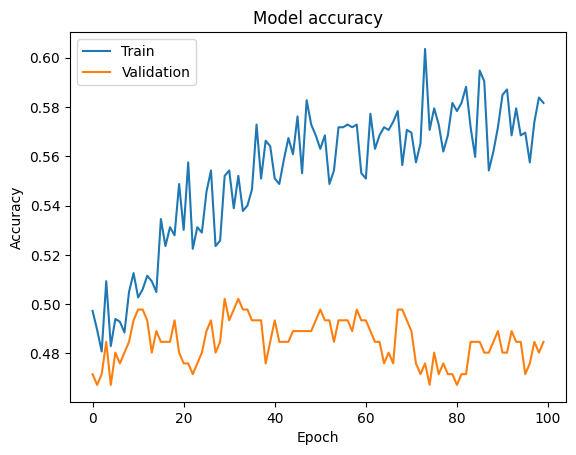

In [399]:
# Plotting training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

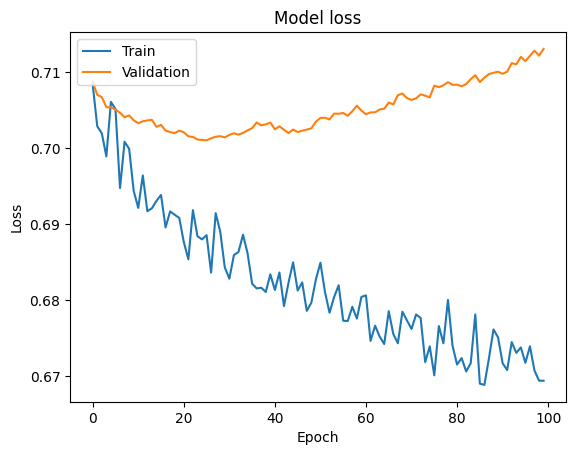

In [400]:
# Plotting training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [369]:
# Make predictions
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)

# Evaluate predictions
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

       False       0.52      0.23      0.31       133
        True       0.55      0.82      0.66       153

    accuracy                           0.54       286
   macro avg       0.53      0.52      0.49       286
weighted avg       0.53      0.54      0.50       286

